In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import glob

import healpy

import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

from astropy.table import Table, vstack
from astropy.io import fits

In [15]:
from damascus import io
from damascus import hsc
from damascus import utils

# Filter DECaLS Sweep catalog through HSC FDFC healpix mask

- Using local DR9SV catalog as a test
- Filter through HSC S19A internal release

In [5]:
decals_dir = '/Volumes/astro5/massive/decals/dr9sv/'
sweep_dir = os.path.join(decals_dir, 'sweep')

hsc_dir = '/Volumes/astro5/massive/s19a/'
s19a_fdfc_mask = os.path.join(
    hsc_dir, 'mask/fdfc/s19a_fdfc_hp_contarea_izy-gt-5_trimmed.fits')

### Find all the sweep catalog

In [6]:
sweep_list = io.find_files(sweep_dir, 'sweep*.fits')

# Find 50 sweep*.fits files


In [9]:
%time sweep_test = Table.read(sweep_list[3])

CPU times: user 486 ms, sys: 4.35 s, total: 4.84 s
Wall time: 46.8 s


In [10]:
%time sweep_test = fits.open(sweep_list[3], memmap=True)[1].data

CPU times: user 499 ms, sys: 905 ms, total: 1.4 s
Wall time: 1.41 s


In [16]:
utils.flux_to_mag(sweep_test['FLUX_G'] / sweep_test['MW_TRANSMISSION_G'], zeropoint=22.5)

/Users/song/Dropbox/work/project/damascus/damascus/utils.py:17: RuntimeWarning: divide by zero encountered in log10
  return -2.5 * np.log10(flux) + zeropoint
/Users/song/Dropbox/work/project/damascus/damascus/utils.py:17: RuntimeWarning: invalid value encountered in log10
  return -2.5 * np.log10(flux) + zeropoint


array([24.492277, 24.89151 , 24.981392, ..., 25.068792, 24.4047  ,
       25.19842 ], dtype=float32)

In [21]:
sweep_test['TYPE'][0] == 'PSF'

True

In [18]:
sweep_test['TYPE'] == 'PSF'

array([ True,  True,  True, ...,  True,  True,  True])

In [17]:
np.unique(sweep_test['TYPE'])

chararray(['DEV', 'DUP', 'EXP', 'PSF', 'REX', 'SER'], dtype='<U3')

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.


(array([8.0000e+00, 3.3000e+01, 1.9200e+02, 8.9400e+02, 2.5240e+03,
        6.2840e+03, 1.3929e+04, 3.5460e+03, 9.5000e+01, 1.4000e+01]),
 array([ 8.754578, 10.905259, 13.055941, 15.206623, 17.357304, 19.507986,
        21.658669, 23.80935 , 25.960032, 28.110712, 30.261395],
       dtype=float32),
 <a list of 10 Patch objects>)

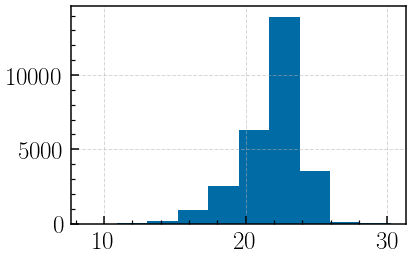

In [13]:
mag_r = -2.5 * np.log10(sweep_test['FLUX_R']) + 22.5

plt.hist(mag_r[np.isfinite(mag_r)])

In [50]:
print(len(sweep_test))

36778


In [11]:
print(sweep_test.colnames)

['RELEASE', 'BRICKID', 'BRICKNAME', 'OBJID', 'TYPE', 'RA', 'DEC', 'RA_IVAR', 'DEC_IVAR', 'DCHISQ', 'EBV', 'FLUX_G', 'FLUX_R', 'FLUX_Z', 'FLUX_W1', 'FLUX_W2', 'FLUX_W3', 'FLUX_W4', 'FLUX_IVAR_G', 'FLUX_IVAR_R', 'FLUX_IVAR_Z', 'FLUX_IVAR_W1', 'FLUX_IVAR_W2', 'FLUX_IVAR_W3', 'FLUX_IVAR_W4', 'MW_TRANSMISSION_G', 'MW_TRANSMISSION_R', 'MW_TRANSMISSION_Z', 'MW_TRANSMISSION_W1', 'MW_TRANSMISSION_W2', 'MW_TRANSMISSION_W3', 'MW_TRANSMISSION_W4', 'NOBS_G', 'NOBS_R', 'NOBS_Z', 'NOBS_W1', 'NOBS_W2', 'NOBS_W3', 'NOBS_W4', 'RCHISQ_G', 'RCHISQ_R', 'RCHISQ_Z', 'RCHISQ_W1', 'RCHISQ_W2', 'RCHISQ_W3', 'RCHISQ_W4', 'FRACFLUX_G', 'FRACFLUX_R', 'FRACFLUX_Z', 'FRACFLUX_W1', 'FRACFLUX_W2', 'FRACFLUX_W3', 'FRACFLUX_W4', 'FRACMASKED_G', 'FRACMASKED_R', 'FRACMASKED_Z', 'FRACIN_G', 'FRACIN_R', 'FRACIN_Z', 'ANYMASK_G', 'ANYMASK_R', 'ANYMASK_Z', 'ALLMASK_G', 'ALLMASK_R', 'ALLMASK_Z', 'WISEMASK_W1', 'WISEMASK_W2', 'PSFSIZE_G', 'PSFSIZE_R', 'PSFSIZE_Z', 'PSFDEPTH_G', 'PSFDEPTH_R', 'PSFDEPTH_Z', 'GALDEPTH_G', 'GALDEPTH

In [14]:
sweep_test['MW_TRANSMISSION_R']

array([0.94814384, 0.94814676, 0.94815373, ..., 0.95754325, 0.9567486 ,
       0.9571302 ], dtype=float32)

In [70]:
def read_healpix_fits(fits_file, nest=True):
    """Read the FITS format healpix file."""
    return healpy.read_map(fits_file, nest=nest, dtype=np.bool)
    
def list_all_sweep_catalogs(sweep_dir, verbose=True):
    """Gather a list of pathes to all SWEEP catalogs."""
    sweep_list = glob.glob(sweep_dir + '/sweep*.fits')
    if verbose:
        print("# Find {:d} SWEEP files".format(len(sweep_list)))
    return sweep_list

def filter_hsc_fdfc_mask(cat, fdfc_mask, ra='RA', dec='DEC', verbose=True):
    """Filter a catalog through HSC FDFC mask."""
    # Read the fits catalog if input is path to the file
    if isinstance(s19a_fdfc_mask, str):
        cat = Table.read(cat)
        
    # Read the healpix mask if input is path to the file
    if isinstance(fdfc_mask, str):
        fdfc_mask = read_healpix_mask(fdfc_mask)
    
    # Find the matched objects
    nside, hp_indices = healpy.get_nside(fdfc_mask), np.where(fdfc_mask)[0]
    phi, theta = np.radians(cat[ra]), np.radians(90. - cat[dec])
    hp_masked = healpy.ang2pix(nside, theta, phi, nest=True)
    select = np.in1d(hp_masked, hp_indices)
    
    if verbose:
        print("# Find {:d} objects inside the FDFC region".format(select.sum()))
    
    if select.sum() < 1:
        return None
    return cat[select]

In [71]:
sweep_list = list_all_sweep_catalogs(sweep_dir)

s19a_fdfc = read_healpix_mask(s19a_fdfc_mask)

matches = [filter_hsc_fdfc_mask(sweep, s19a_fdfc) for sweep in sweep_list]

# Find 50 SWEEP files
NSIDE = 1024
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
Ordering converted to NEST
# Find 48692 objects inside the FDFC region
# Find 23804 objects inside the FDFC region
# Find 3461144 objects inside the FDFC region
# Find 1486488 objects inside the FDFC region
# Find 0 objects inside the FDFC region
# Find 0 objects inside the FDFC region
# Find 0 objects inside the FDFC region
# Find 134507 objects inside the FDFC region
# Find 300026 objects inside the FDFC region
# Find 1351614 objects inside the FDFC region
# Find 2761847 objects inside the FDFC region
# Find 0 objects inside the FDFC region
# Find 0 objects inside the FDFC region
# Find 0 objects inside the FDFC region
# Find 132510 objects inside the FDFC region
# Find 262544 objects inside the FDFC region
# Find 0 objects inside the FDFC region
# Find 0 objects inside the FDFC region
# Find 0 objects inside the FDFC region
# Find 0 objects inside the FDFC region
# Find 0 objects inside the FDFC regi

In [74]:
matches_use = list(filter(None, matches)) 

print(len(matches_use))

18


In [76]:
dr9sv_matches = vstack(matches_use)

In [77]:
len(dr9sv_matches)

16695183

In [ ]:
dr9sv_matches.write('/Volumes/astro5/massive/decals/dr9sv/dr9sv_sweep_s19a_fdfc_all.fits')